## Lab 3: Circuit Analysis in a Convolutional Neural Network

Team: Mike Wisniewski, Henry Lambson, Alex Gregory

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [8]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

>[3 Points] In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet). These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.) https://keras.io/api/applications/
>
>   - It is recommended to select a model with somewhat simple structure, like VGG. This can help to simplify how to extract specific filters and inputs to filters later on.  
>   - Explain the model you chose and why.  Classify a few images with pre-trained network to verify that it is working properly.


In [2]:
# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False, input_tensor=None)

# set VGG to be frozen
for layer in model.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 5s 0us/step


In [3]:
# classify some images

>[4 Points] Select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit. This should be a multi-channel filter in a "mid-level" portion of the network (that is, there are a few convolutional layers before and after this chosen layer). You might find using OpenAI microscope a helpful tool for selecting a filter to analyze without writing too much code: https://microscope.openai.com/models/
>
>   - Using image gradient techniques, find an input image that maximally excites this chosen multi-channel filter. General techniques are available from class: https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynb 
>   - Also send images of varying class (i.e. from ImageNet) through the network and track which classes of images most excite your chosen filter. 
>   - Give a hypothesis for what this multi-channel filter might be extracting. That is, what do you think its function is in the network? 
>   - If using code from another source, you must heavily document the code so that I can grade your understanding of the code used. 

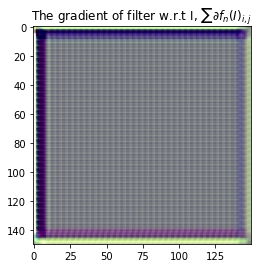

In [9]:
# Selecting a layer and channel to visualize
layer_name = 'block3_conv1'
filter_index = 0
 
# Isolate the output of interest and create new model
layer_output = model.get_layer(layer_name).output
new_model = models.Model(inputs=model.input, outputs=layer_output)
# now "new_model" has the output we desire to maximize

# create a variable that we can access and update in computation graph
I = tf.Variable(np.zeros((1, 150, 150, 3),dtype='double'), name='image_var', dtype = 'float64')

# now use gradient tape to get the gradients (watching only the variable v)
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(I) # watch
    model_vals = new_model(preprocess_input(I)) # get output
    filter_output_to_maximize = tf.reduce_mean(model_vals[:, :, :, filter_index]) # define what we want to maximize
    
grad_fn = tape.gradient(filter_output_to_maximize, I) # get gradients that influence loss w.r.t. v
grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm (better stability)

# now show the gradient, same size as input image
plt.imshow(prepare_image_for_display( grad_fn.numpy(), norm_type='std'))
plt.title('The gradient of filter w.r.t I, $ \sum\partial f_n(I)_{i,j} $ ')
plt.show()

>[4 Points] Analyze each channel of the multi-channel filter to this feature that might form a circuit. That is, visualize the convolutional filter (one channel) between the input activations and the current activation to understand which inputs make up a circuit. One method of doing this is given below:
>
>   - Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5. 
>   - Keep the top six sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top six filters. 
>   - For these six strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?  


>[4 Points] For each of the six chosen single channels of the filter, use image gradient techniques to visualize what each of these filters is most excited by (that is, what image maximally excites each of these filters?). This is a similar analysis to the first step, but now isolating the filters directly before your chosen filter. 

>   - Use these visualizations, along with the circuit weights you just discovered to try and explain how this particular circuit works. An example of this visualization style can be seen here: https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/mixed3b_379.html 
>   - Try to define the properties of this circuit using vocabulary from https://distill.pub/2020/circuits/zoom-in/ (such as determining if this is polysemantic, pose-invariant, etc.)  
>   - Relate your visualizations back to your original hypothesis about what this filter is extracting. Does it support or refute your hypothesis? Why? 

## Final Analysis